**Use 'opendataset' library to download dataset from kaggle**

In [1]:
!pip install opendatasets --upgrade --quiet

**Import Libraries**

In [2]:
import opendatasets as od
import os
import cv2

import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

from tqdm.notebook import tqdm
from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

**Download Dataset**

In [3]:
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mdshamimur
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:06<00:00, 65.6MB/s]


**List of Directories and Contents**

In [4]:
DATA_DIR = './animefacedataset'
print('List of directory: ',os.listdir(DATA_DIR))
print('Sample of Contents: ',os.listdir(DATA_DIR + '/images')[:10] )

List of directory:  ['images']
Sample of Contents:  ['19665_2007.jpg', '14357_2006.jpg', '29094_2010.jpg', '34220_2011.jpg', '40278_2012.jpg', '38652_2012.jpg', '4778_2003.jpg', '12840_2005.jpg', '12460_2005.jpg', '48346_2014.jpg']


**Data Preprocessing (Transform images into tensor with Normalization)**

In [5]:
image_size = 64
batch_size = 128
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [6]:
#Image to Tensor
data_ds = ImageFolder(DATA_DIR, 
                      transform= T.Compose([
                                            T.Resize(image_size),
                                            T.CenterCrop(image_size),
                                            T.ToTensor(),
                                            T.Normalize(*stats)
                      ]))
#Load the data
data_dl = DataLoader(data_ds, batch_size, 
                     shuffle = True, num_workers= 2, 
                     pin_memory = True)

**Show Sample Image from Loaded Data**

In [10]:
#Denormalize the Image Tensors
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

#Showing Image
def show_images(images, nmax = 64):
  fig, ax = plt.subplots(figsize = (8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow = 8).permute(1, 2, 0))

#Show a sample batch of Images
def show_batch(dl, nmax = 64):
  for images, _ in dl:
    show_images(images, nmax)
    break

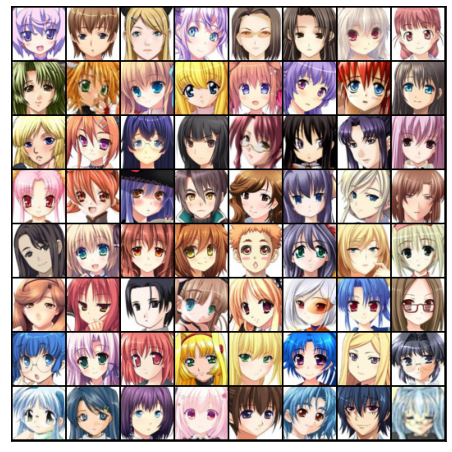

In [11]:
show_batch(data_dl)

**Using a GPU**

In [14]:
#GPU Setup

def get_default_device():
  """If GPU is available use CUDA, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move Tensors to Chosen Device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  """Wrap a DataLoader to Move Data to Device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a Batch of Data Moving it to a Device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of Batched Data"""
    return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

**Load Data to Chosen Device**

In [16]:
train_dl = DeviceDataLoader(data_dl, device)

### ***Creating Networks ***

**Discriminator Network (Adversary)**

In [17]:
discriminator = nn.Sequential(
    #Input: 3 X 64 X 64
    
    nn.Conv2d(3, 64, kernel_size= 4, stride= 2, padding= 1, bias= False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace= True),
    #Output: 64 X 32 X 32

    nn.Conv2d(64, 128, kernel_size= 4, stride= 2, padding= 1, bias= False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace= True),
    #Output: 128 X 16 X 16

    nn.Conv2d(128, 256, kernel_size= 4, stride= 2, padding= 1, bias= False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace= True),
    #Output: 256 X 8 X 8

    nn.Conv2d(256, 512, kernel_size= 4, stride= 2, padding= 1, bias= False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace= True),
    #Output: 512 X 4 X 4

    nn.Conv2d(512, 1, kernel_size= 4, stride= 2, padding= 0, bias= False),
    #Output: 512 X 1 X 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [18]:
#Move Discriminator Model to Chosen Device
discriminator = to_device(discriminator, device)

**Generator Model**

In [19]:
latent_size = 128

generator = nn.Sequential(
    #Input: 128 X 1 X 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size= 4, stride= 1, padding= 0, bias= False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #Output: 512 X 4 X 4

    nn.ConvTranspose2d(512, 256, kernel_size= 4, stride= 2, padding= 1, bias= False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #Output: 256 X 8 X 8

    nn.ConvTranspose2d(256, 128, kernel_size= 4, stride= 2, padding= 1, bias= False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #Output: 128 X 16 X 16

    nn.ConvTranspose2d(128, 64, kernel_size= 4, stride= 2, padding= 1, bias= False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #Output: 64 X 32 X 32

    nn.ConvTranspose2d(64, 3, kernel_size= 4, stride= 2, padding= 1, bias= False),
    nn.Tanh()
    #Output: 3 X 64 X 64
)

In [20]:
#Move Generator to Chosen Device
generator = to_device(generator, device)

## **Training the Models**

**Discriminator Training**

In [21]:
def train_discriminator(real_images, opt_d):
  #Clear Discriminator Gradients 
  opt_d.zero_grad()

  #Pass Real Images through Discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device= device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  #Generate Fake Images
  latent = torch.randn(batch_size, latent_size, 1, 1, device= device)
  fake_images = generator(latent)

  #Pass Fake Images Through Discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device= device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  #Update Discriminator Weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

**Generator Training**

In [27]:
def train_generator(opt_g):
  #Clear Generator Gradients
  opt_g.zero_grad()

  #Generate Fake Images
  latent = torch.randn(batch_size, latent_size, 1, 1, device= device)
  fake_images = generator(latent)

  #Try to fool the Discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device= device)
  loss = F.binary_cross_entropy(preds, targets)

  #Update Generator Weights
  loss.backward()
  opt_g.step()

  return loss.item()

**Save Generated Images**

In [23]:
#Create Directory to Save Images
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok= True)

In [24]:
#Save Sample Images (Generated)

def save_sample(index, latent_tensors, show = True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 8)
  print('saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1, 2, 0))

In [37]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device= device)

# **Full Training Loop**

In [35]:
def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()

  #Losses and Scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  #Cteate Optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(),
                           lr = lr, betas = (0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(),
                           lr = lr, betas = (0.5, 0.999))
  
  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      #Train Discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

      #Train Generator
      loss_g = train_generator(opt_g)

    #Record Losses and Scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    #Log Losses and Scores (Last Batch)
    print("Epoch [{} / {}], Generator_loss: {:.4f}, Discriminator_loss: {:.4f}, Real_score: {:.4f}, Fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
    #Save Images
    save_sample(epoch+start_idx, fixed_latent, show = False)
  
  return losses_g, losses_d, real_scores, fake_scores

In [38]:
lr = 0.0001
epochs = 10

history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1 / 10], Generator_loss: 2.4768, Discriminator_loss: 0.3461, Real_score: 0.7974, Fake_score: 0.0353
saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2 / 10], Generator_loss: 2.5235, Discriminator_loss: 0.4053, Real_score: 0.7251, Fake_score: 0.0109
saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3 / 10], Generator_loss: 3.4760, Discriminator_loss: 0.1902, Real_score: 0.9789, Fake_score: 0.1414
saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4 / 10], Generator_loss: 5.3833, Discriminator_loss: 0.2287, Real_score: 0.8262, Fake_score: 0.0125
saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5 / 10], Generator_loss: 3.9594, Discriminator_loss: 0.1464, Real_score: 0.9587, Fake_score: 0.0920
saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6 / 10], Generator_loss: 4.8174, Discriminator_loss: 0.2446, Real_score: 0.9730, Fake_score: 0.1765
saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7 / 10], Generator_loss: 3.4787, Discriminator_loss: 0.2547, Real_score: 0.9299, Fake_score: 0.1453
saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8 / 10], Generator_loss: 4.3412, Discriminator_loss: 0.2696, Real_score: 0.9493, Fake_score: 0.1762
saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9 / 10], Generator_loss: 4.3796, Discriminator_loss: 0.1075, Real_score: 0.9761, Fake_score: 0.0770
saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10 / 10], Generator_loss: 4.0279, Discriminator_loss: 0.1479, Real_score: 0.9520, Fake_score: 0.0872
saving generated-images-0010.png


**Save Model Check Points**

In [39]:
losses_g, losses_d, real_scores, fake_scores = history

In [41]:
#Save the Model

torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

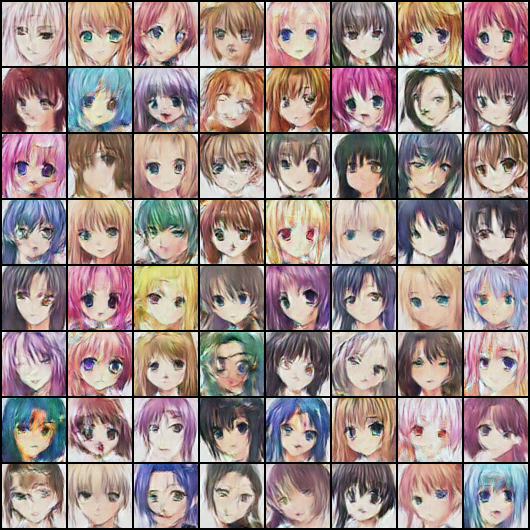

In [44]:
#Show Generated Images
Image('./generated/generated-images-0010.png')

**Training Progress as a Video**

In [45]:
vid_fname = 'gans_training.mkv'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

**Plot Showing as Progress**

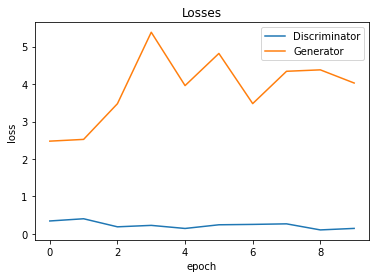

In [46]:
#Loss plot

plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

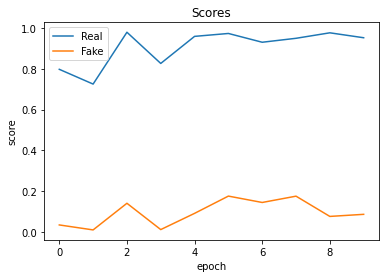

In [47]:
#Scores plot

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');